# How to train a Variational Autoencoder for MNIST

In [1]:
import os
os.chdir("../")

import numpy as np
import numpy.matlib as matlib
import networkx as nx
import matplotlib.pyplot as plt
import logging
import os
import json
import copy
import time

from nn import MLP
from activations import Identity, Sigmoid, Tanh, ReLU, LeakyReLU, Softmax, Activation
from loss import MSE, CrossEntropy
from tensorboardX import SummaryWriter
from dataset import Dataset
from optimizer import Adam, SGD
from layers import Dense
from my_utils import prettyTime
from vae import VAE, Sampler

# import the plotting library
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.plotting import figure 
output_notebook()

logging.basicConfig(level=logging.DEBUG , format='[%(asctime)s] - [%(levelname)s] - %(message)s')

# get current time in milliseconds
millis = lambda: int(round(time.time() * 1000))
REFRESH_RATE = 5 * 1000 # refresh plot every ___ milliseconds
lastTimes = {"loss": 0, "accuracy": 0}

HIDDEN_SIZE = 256 # 512
LATENT_SIZE = 32 # 64

Loading BokehJS ...

## Live Plots

In [2]:
plotLoss = figure(tools="crosshair,pan,wheel_zoom,box_zoom,reset,tap,box_select,lasso_select", title= "Loss" , plot_height = 350, plot_width = 800)
xLoss = [[],[]]
yLoss = [[],[]]
plotLoss.multi_line(xs=xLoss,ys=yLoss)
targetLoss = show(plotLoss, notebook_handle = True)

In [3]:
def plot_callback(plotObj, xValues, yValues, targetObject, newX, newY, plotType, train = True):
    # 1. append new data
    i = 0 if train else 1
    xValues[i].append(newX)
    yValues[i].append(newY)
    
    # only update plot after REFRESH_DATE has passed
    if millis() - lastTimes[plotType] > REFRESH_RATE:
        lastTimes[plotType] = millis()
        
        # 2. draw two line plots
        colors = ["mediumblue", "darkorange"]
        legends = ["train", "test"]
        for i in range(2):
            plotObj.line(x=xValues[i],y=yValues[i], color=colors[i], legend_label=legends[i])
        plotObj.legend.location = "top_left"
    
        # 3. push notebook to its target
        push_notebook(handle = targetObject)
    
train_loss_callback = lambda x, y: plot_callback(plotLoss, xLoss, yLoss, targetLoss, x, y, "loss", train = True)
test_loss_callback = lambda x, y: plot_callback(plotLoss, xLoss, yLoss, targetLoss, x, y, "loss", train = False)

## Training

In [4]:
dataset = Dataset(name = "mnist", train_size = 60000, test_size = 10000, batch_size = 10)

# set the learning rate and optimizer for training
optimizer = Adam(1e-2)

encoder = MLP()
encoder.addLayer(Dense(inputDim = 28 * 28, outputDim = HIDDEN_SIZE, activation = ReLU(), optimizer = optimizer))
sampler = Sampler(HIDDEN_SIZE,LATENT_SIZE,optimizer = optimizer) 

decoder = MLP()
decoder.addLayer(Dense(inputDim = LATENT_SIZE, outputDim = HIDDEN_SIZE, activation = ReLU(), optimizer = optimizer))
decoder.addLayer(Dense(inputDim = HIDDEN_SIZE, outputDim = 28 * 28, activation = Sigmoid(), optimizer = optimizer))

vae = VAE(encoder, sampler, decoder)
print(vae)

-------------------- VARIATIONAL AUTOENCODER (VAE) --------------------

TOTAL PARAMETERS = 427344 

###############
#   ENCODER   #
###############

 *** 1. Layer: *** 
------------------------
DENSE 784 -> 256 [ReLU]
------------------------
Total parameters: 200960 
---> WEIGHTS: (256, 784)
---> BIASES: (256,)
------------------------

###############
#   SAMPLER   #
###############

 *** MEAN Layer: *** 
---------------------------
DENSE 256 -> 32 [Identity]
---------------------------
Total parameters: 8224 
---> WEIGHTS: (32, 256)
---> BIASES: (32,)
---------------------------

 *** LOG_VAR Layer: *** 
---------------------------
DENSE 256 -> 32 [Identity]
---------------------------
Total parameters: 8224 
---> WEIGHTS: (32, 256)
---> BIASES: (32,)
---------------------------

###############
#   DECODER   #
###############

 *** 1. Layer: *** 
-----------------------
DENSE 32 -> 256 [ReLU]
-----------------------
Total parameters: 8448 
---> WEIGHTS: (256, 32)
---> BIASES: (256

In [5]:
# define callback dictionary, in which loss and accuracy callbacks are stored
my_callbacks = {"train_loss": train_loss_callback, "test_loss": test_loss_callback}
# works faster without live plots

In [6]:
vae.train(dataset,loss = MSE(), epochs = 10, metrics = ["train_loss", "test_loss"], tensorboard = False, callbacks = my_callbacks)

[2020-07-05 21:24:09,266] - [DEBUG] -  *** EPOCH 1/10 ***
[2020-07-05 21:25:13,102] - [DEBUG] -  *** EPOCH 2/10 ***
[2020-07-05 21:26:15,736] - [DEBUG] -  *** EPOCH 3/10 ***
[2020-07-05 21:27:18,859] - [DEBUG] -  *** EPOCH 4/10 ***
[2020-07-05 21:28:22,514] - [DEBUG] -  *** EPOCH 5/10 ***
[2020-07-05 21:29:26,871] - [DEBUG] -  *** EPOCH 6/10 ***
[2020-07-05 21:30:32,235] - [DEBUG] -  *** EPOCH 7/10 ***
[2020-07-05 21:31:41,117] - [DEBUG] -  *** EPOCH 8/10 ***
[2020-07-05 21:32:49,207] - [DEBUG] -  *** EPOCH 9/10 ***
[2020-07-05 21:33:58,893] - [DEBUG] -  *** EPOCH 10/10 ***


In [7]:
#vae.save("mnist_variational_autoencoder")

In [8]:
testDataset = Dataset(name = "mnist", train_size = 60000, test_size = 10000, batch_size = 1)

In [9]:
sample = next(testDataset.batches())

In [10]:
# forward propagate the test data
output = vae.feedforward(sample[1][0])

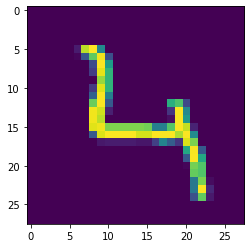

In [14]:
plt.imshow(sample[1][0].reshape(28,28))
plt.show()

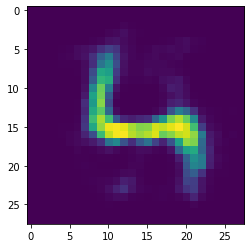

In [15]:
plt.imshow(output.reshape(28,28))
plt.show()

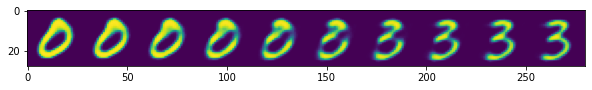

In [20]:
n = 10
digit_size = 28
images = np.zeros((digit_size, digit_size*n))

img1 = next(testDataset.batches())
vae.feedforward(img1[1][0])
z_img1 = vae.sampler.sample

img2 = next(testDataset.batches())
vae.feedforward(img2[1][0])
z_img2 = vae.sampler.sample

for i in range(n):
    z = (z_img1 * (n-1-i) + z_img2 * i) / (n-1)
    images[:,i*28:(i+1)*28] = vae.decoder.feedforward(z).reshape(28,28)

plt.figure(figsize=(10, 10))
plt.imshow(images)
plt.show()